In [1]:
%load_ext google.cloud.bigquery

In [2]:
# This is the correct way to auth with https://colab.google.com/
# Authentication may be different on different jupyter platforms

from google.colab import auth
auth.authenticate_user()  # this will trigger a flow to authenticate your account

from google.cloud.bigquery import magics
magics.context.project = 'firehook-censoredplanet'  # Change to your own project which has access to the tables

In [4]:
import functools
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Sample some random data just to see the data format

In [5]:
%%bigquery
SELECT *
FROM firehook-censoredplanet.merged_results.cleaned_error_scans
LIMIT 10

,date,domain,country,asn,as_name,ip,netblock,as_class,source,result,count
0,2019-12-11,herokuapp.com,AT,35765,Gemeindewerke Telfs GmbH,87.247.203.250,87.247.200.0/22,Transit/Access,ECHO,ECHO: EOF,1
1,2019-12-11,www.xenu.net,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
2,2019-12-11,www.centcom.mil,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
3,2019-12-11,www.slideshare.net,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
4,2019-12-11,cnnindonesia.com,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
5,2019-12-11,www.pc2call.com,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
6,2019-12-11,disqus.com,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
7,2019-12-11,baidu.com,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
8,2019-12-11,deepl.com,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1
9,2019-12-11,haofang.net,AE,5384,Emirates Telecommunications Corporation,2.50.32.53,2.50.0.0/18,Transit/Access,ECHO,ECHO: null,1


> Belarus: Internet Disruptions, Online Censorship

> Belarusian authorities are disrupting internet access and restricting content online in response to peaceful, countrywide protests, Human Rights Watch said today. **For over 18 days**, protesters have demanded fair presidential elections and investigations into police brutality against demonstrators. 

> Protests have been ongoing in Belarus since **August 9, 2020**, when the official results of the presidential election, which the demonstrators contend was rigged, were announced, prolonging Alexander Lukashenka’s 25-year rule.

https://www.hrw.org/news/2020/08/28/belarus-internet-disruptions-online-censorship

Get all Belarus scans from August 2020

In [6]:
%%bigquery belarus_scans
SELECT *
FROM firehook-censoredplanet.merged_results.cleaned_error_scans
WHERE country = 'BY' AND
      date > '2020-08-01' AND date < '2020-08-31'

In [7]:
belarus_scans[:10]

,date,domain,country,asn,as_name,ip,netblock,as_class,source,result,count
0,2020-08-10,eikegolehem.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
1,2020-08-10,ukr.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
2,2020-08-10,massbrowser.cs.umass.edu,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
3,2020-08-10,trashy.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
4,2020-08-10,www.circumcision.org,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
5,2020-08-10,www.lushstories.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
6,2020-08-10,kakao.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
7,2020-08-10,khilafah.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
8,2020-08-10,www.grindr.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
9,2020-08-10,lun.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1


In [8]:
len(belarus_scans)

3323142

Beltelecom (asn 6697) is the main ISP in Belarus

In [9]:
belarus_scans.groupby(['asn', 'as_name']).sum().sort_values(['count'],ascending=False)[:5]

,,count
asn,as_name,
6697,Republican Unitary Telecommunication Enterprise Beltelecom,1696049
12406,Business Network Ltd,295554
38980,Priorbank JSC,267118
202090,Aktivnie Tehnologii LLC,214383
51365,"JSC ""Belinvestbank""",139931


In [10]:
beltelecom_scans = belarus_scans[belarus_scans.asn.eq(6697)]
beltelecom_scans[:10]

,date,domain,country,asn,as_name,ip,netblock,as_class,source,result,count
0,2020-08-10,eikegolehem.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
1,2020-08-10,ukr.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
2,2020-08-10,massbrowser.cs.umass.edu,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
3,2020-08-10,trashy.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
4,2020-08-10,www.circumcision.org,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
5,2020-08-10,www.lushstories.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
6,2020-08-10,kakao.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
7,2020-08-10,khilafah.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1
8,2020-08-10,www.grindr.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1
9,2020-08-10,lun.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1


In [11]:
# Null means the measurement succeeded, any other results means some kind of error or interference.
# ECHO/DISCARD/HTTP/HTTPS are different types of measurements.

results = beltelecom_scans.groupby(['result'],as_index=False)['count'].sum().sort_values(['count'],ascending=False)['result']
list(results)

['HTTP: null',
 'HTTPS: null',
 'ECHO: null',
 'DISCARD: null',
 'HTTP: Get http://[IP]: net/http: request canceled (Client.Timeout exceeded while awaiting headers)',
 'HTTPS: Get https://[IP]: net/http: request canceled while waiting for connection (Client.Timeout exceeded while awaiting headers)',
 'DISCARD: read tcp [IP]:[PORT]->[IP]:[PORT]: i/o timeout',
 "HTTP: Incorrect web response: status lines don't match",
 'HTTPS: Get https://[IP]: read tcp [IP]:[PORT]->[IP]:[PORT]: read: connection reset by peer',
 'ECHO: read tcp [IP]:[PORT]->[IP]:[PORT]: i/o timeout',
 'DISCARD: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection refused',
 'HTTP: Get http://[IP]: net/http: request canceled while waiting for connection (Client.Timeout exceeded while awaiting headers)',
 'HTTP: Get http://[IP]: EOF',
 'ECHO: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection refused',
 "HTTPS: Incorrect web response: status lines don't match",
 'HTTPS: Get https://[IP]: net/http: request canceled (C

In [12]:
success_results = [
  'HTTP: null',
  'HTTPS: null',
  'ECHO: null',
  'DISCARD: null'
]
interference_results = [
  'HTTP: Get http://[IP]: net/http: request canceled (Client.Timeout exceeded while awaiting headers)',
  'HTTPS: Get https://[IP]: net/http: request canceled while waiting for connection (Client.Timeout exceeded while awaiting headers)',
  'DISCARD: read tcp [IP]:[PORT]->[IP]:[PORT]: i/o timeout',
  "HTTP: Incorrect web response: status lines don't match",
  'HTTPS: Get https://[IP]: read tcp [IP]:[PORT]->[IP]:[PORT]: read: connection reset by peer',
  'ECHO: read tcp [IP]:[PORT]->[IP]:[PORT]: i/o timeout',
  'DISCARD: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection refused',
  'HTTP: Get http://[IP]: net/http: request canceled while waiting for connection (Client.Timeout exceeded while awaiting headers)',
  'ECHO: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection refused',
  "HTTPS: Incorrect web response: status lines don't match",
  'HTTPS: Get https://[IP]: net/http: request canceled (Client.Timeout exceeded while awaiting headers)',
  'ECHO: Incorrect echo response',
  'DISCARD: Received response',
  'DISCARD: read tcp [IP]:[PORT]->[IP]:[PORT]: read: connection reset by peer',
  "HTTPS: Incorrect web response: bodies don't match",
  'ECHO: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection timed out',
  'DISCARD: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: connection timed out',
  'ECHO: dial tcp [IP]:[PORT]->[IP]:[PORT]: connect: no route to host',
  'ECHO: read tcp [IP]:[PORT]->[IP]:[PORT]: read: connection reset by peer',
  'HTTP: Get http://[IP]: read tcp [IP]:[PORT]->[IP]:[PORT]: read: connection reset by peer',
  'HTTP: Get http://[IP]: dial tcp [IP]:[PORT]: getsockopt: connection refused'               
]
error_results = [
  'HTTP: Get http://[IP]: EOF',
  'HTTPS: Get https://[IP]: EOF', 
]                   

In [13]:
def classify_result(result):
  if result in success_results:
    return 'success'
  elif result in interference_results:
    return 'interference'
  elif result in error_results:
    return 'system_error'
  else:
    return unknown

result_types = beltelecom_scans['result'].map(classify_result)
beltelecom_scans['result_types'] = result_types

beltelecom_scans[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,date,domain,country,asn,as_name,ip,netblock,as_class,source,result,count,result_types
0,2020-08-10,eikegolehem.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1,success
1,2020-08-10,ukr.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1,success
2,2020-08-10,massbrowser.cs.umass.edu,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1,success
3,2020-08-10,trashy.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1,success
4,2020-08-10,www.circumcision.org,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1,success
5,2020-08-10,www.lushstories.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1,success
6,2020-08-10,kakao.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1,success
7,2020-08-10,khilafah.net,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1,success
8,2020-08-10,www.grindr.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.244.10,178.172.244.0/24,Transit/Access,HTTP,HTTP: null,1,success
9,2020-08-10,lun.com,BY,6697,Republican Unitary Telecommunication Enterpris...,178.172.173.188,178.172.172.0/23,Transit/Access,HTTP,HTTP: null,1,success


In [14]:
# Get the ratios for each type of result per domain and source type (for the whole bunch)
counts_per_domain = beltelecom_scans.groupby(['domain','source'])[['domain', 'source', 'count']].sum()
results_per_domain = beltelecom_scans.groupby(['domain', 'source', 'result_types'])[['domain', 'result_types', 'source', 'count']].sum()

# flatten levels
results_per_domain = pd.DataFrame(results_per_domain.to_records(), columns=results_per_domain.index.names + list(results_per_domain.columns))

success_per_domain = results_per_domain[results_per_domain['result_types'].eq('success')]
interference_per_domain = results_per_domain[results_per_domain['result_types'].eq('interference')]

success_ratios = success_per_domain['count'].div(success_per_domain['count'] + interference_per_domain['count'])

both_ratios = pd.merge(success_per_domain[['domain', 'source', 'count']], interference_per_domain[['domain', 'source', 'count']],
                       on=['domain', 'source'], how='outer')
both_ratios.rename(columns = {'count_x':'success_count', 'count_y':'interference_count'}, inplace = True)
both_ratios['total_count'] = both_ratios['success_count'].fillna(0) + both_ratios['interference_count'].fillna(0)
both_ratios['success_ratio'] = both_ratios['success_count'].fillna(0).div(both_ratios['total_count'])
both_ratios['interference_ratio'] = both_ratios['interference_count'].fillna(0).div(both_ratios['total_count'])

both_ratios[:10]

,domain,source,success_count,interference_count,total_count,success_ratio,interference_ratio
0,0klxjejyxak3.com,HTTP,310,NaN,310.0,1.00000,0.00000
1,0klxjejyxak3.com,HTTPS,172,NaN,172.0,1.00000,0.00000
2,104.com.tw,DISCARD,92,NaN,92.0,1.00000,0.00000
3,104.com.tw,ECHO,99,NaN,99.0,1.00000,0.00000
4,104.com.tw,HTTP,410,NaN,410.0,1.00000,0.00000
5,104.com.tw,HTTPS,237,NaN,237.0,1.00000,0.00000
6,11st.co.kr,DISCARD,47,NaN,47.0,1.00000,0.00000
7,11st.co.kr,ECHO,56,NaN,56.0,1.00000,0.00000
8,11st.co.kr,HTTP,364,1.0,365.0,0.99726,0.00274
9,11st.co.kr,HTTPS,203,NaN,203.0,1.00000,0.00000


In [15]:
# find domains with very low success ratios, this helps us look for blocking

sorted_ratios = both_ratios.sort_values(['success_ratio'])
sorted_ratios[:20]

,domain,source,success_count,interference_count,total_count,success_ratio,interference_ratio
6938,www.crazyshit.com,HTTP,12,2039.0,2051.0,0.005851,0.994149
6939,www.crazyshit.com,HTTPS,9,1125.0,1134.0,0.007937,0.992063
4676,psiphon.ca,HTTP,119,1462.0,1581.0,0.075269,0.924731
4677,psiphon.ca,HTTPS,104,670.0,774.0,0.134367,0.865633
4675,psiphon.ca,ECHO,46,273.0,319.0,0.144201,0.855799
5839,tutanota.com,HTTPS,110,642.0,752.0,0.146277,0.853723
4674,psiphon.ca,DISCARD,50,230.0,280.0,0.178571,0.821429
2519,google.pt,DISCARD,22,56.0,78.0,0.282051,0.717949
5838,tutanota.com,HTTP,275,692.0,967.0,0.284385,0.715615
4653,protonmail.com,HTTPS,169,329.0,498.0,0.339357,0.660643


In [16]:
# Do the same as above, but get results per day instead of aggregating the whole month

dated_counts_per_domain = beltelecom_scans.groupby(['date','domain','source'])[['date','domain', 'source', 'count']].sum()
dated_results_per_domain = beltelecom_scans.groupby(['date','domain', 'source', 'result_types'])[['date','domain', 'result_types', 'source', 'count']].sum()

# flatten levels
dated_results_per_domain = pd.DataFrame(dated_results_per_domain.to_records(), columns=dated_results_per_domain.index.names + list(dated_results_per_domain.columns))

dated_success_per_domain = dated_results_per_domain[dated_results_per_domain['result_types'].eq('success')]
dated_interference_per_domain = dated_results_per_domain[dated_results_per_domain['result_types'].eq('interference')]

dated_success_ratios = dated_success_per_domain['count'].div(dated_success_per_domain['count'] + dated_interference_per_domain['count'])

dated_both_ratios = pd.merge(dated_success_per_domain[['date', 'domain', 'source', 'count']], dated_interference_per_domain[['date', 'domain', 'source', 'count']],
                       on=['date', 'domain', 'source'], how='outer')
dated_both_ratios.rename(columns = {'count_x':'success_count', 'count_y':'interference_count'}, inplace = True)
dated_both_ratios['total_count'] = dated_both_ratios['success_count'].fillna(0) + dated_both_ratios['interference_count'].fillna(0)
dated_both_ratios['success_ratio'] = dated_both_ratios['success_count'].fillna(0).div(dated_both_ratios['total_count'])
dated_both_ratios['interference_ratio'] = dated_both_ratios['interference_count'].fillna(0).div(dated_both_ratios['total_count'])

dated_results_ratios = dated_both_ratios
dated_both_ratios[:10]

,date,domain,source,success_count,interference_count,total_count,success_ratio,interference_ratio
0,2020-08-02,0klxjejyxak3.com,HTTP,45.0,NaN,45.0,1.0,0.0
1,2020-08-02,104.com.tw,DISCARD,9.0,NaN,9.0,1.0,0.0
2,2020-08-02,104.com.tw,ECHO,7.0,NaN,7.0,1.0,0.0
3,2020-08-02,104.com.tw,HTTP,45.0,NaN,45.0,1.0,0.0
4,2020-08-02,11st.co.kr,HTTP,46.0,NaN,46.0,1.0,0.0
5,2020-08-02,123rf.com,HTTP,45.0,NaN,45.0,1.0,0.0
6,2020-08-02,126.com,HTTP,45.0,NaN,45.0,1.0,0.0
7,2020-08-02,1337x.to,DISCARD,9.0,NaN,9.0,1.0,0.0
8,2020-08-02,1337x.to,ECHO,7.0,NaN,7.0,1.0,0.0
9,2020-08-02,1337x.to,HTTP,46.0,NaN,46.0,1.0,0.0


In [17]:
psiphon_success_by_source = dated_results_ratios[
                         (dated_results_ratios['domain'].eq('psiphon.ca'))].sort_values(['date'])[['date', 'success_ratio', 'source']]
psiphon_success = psiphon_success_by_source.pivot(index='date', columns='source', values='success_ratio')
psiphon_success

source,DISCARD,ECHO,HTTP,HTTPS
date,,,,
2020-08-02,1.000000,1.00,1.000000,NaN
2020-08-03,1.000000,NaN,NaN,1.000000
2020-08-05,NaN,1.00,1.000000,NaN
2020-08-06,1.000000,1.00,NaN,1.000000
2020-08-08,1.000000,1.00,NaN,NaN
2020-08-09,0.024390,0.00,0.033333,NaN
2020-08-10,0.000000,NaN,0.000000,0.000000
2020-08-11,NaN,NaN,NaN,1.000000
2020-08-12,NaN,0.00,0.031414,NaN


No source covers all days, but different sources can support each other.

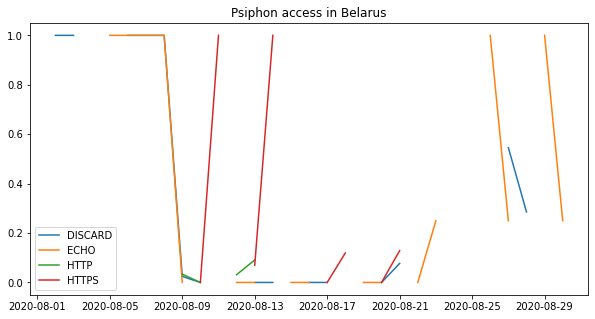

In [18]:
plt.figure(figsize=(10,5))
plt.plot(psiphon_success)

plt.legend(psiphon_success.columns)
plt.title("Psiphon access in Belarus")
plt.show()

In [19]:
def graph_domain(domain):
  domain_success_by_source = dated_results_ratios[
                         (dated_results_ratios['domain'].eq(domain))].sort_values(['date'])[['date', 'success_ratio', 'source']]
  domain_success = domain_success_by_source.pivot(index='date', columns='source', values='success_ratio')
  
  plt.figure(figsize=(10,5))
  plt.plot(domain_success)
  plt.legend(domain_success.columns)
  plt.title(domain + " access in Belarus")
  plt.show()

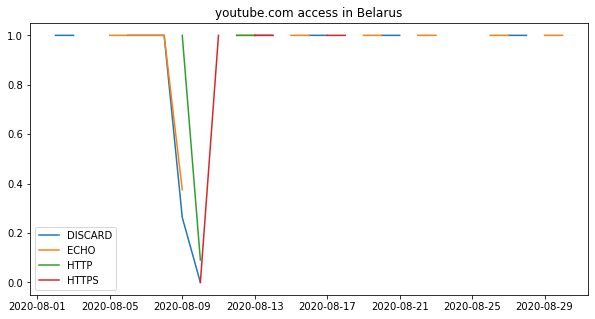

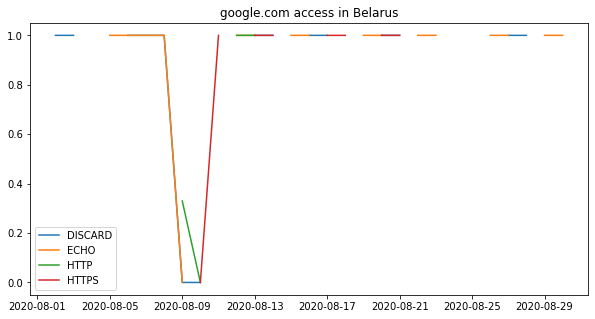

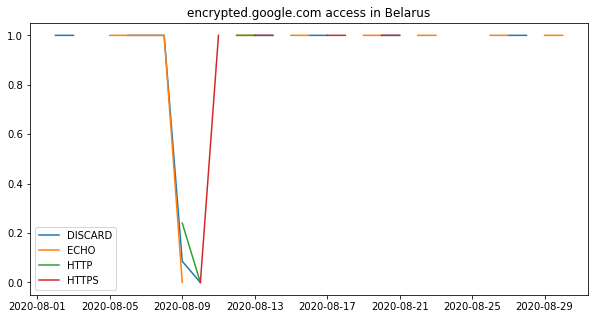

In [20]:
graph_domain('youtube.com')
graph_domain('google.com')
graph_domain('encrypted.google.com')

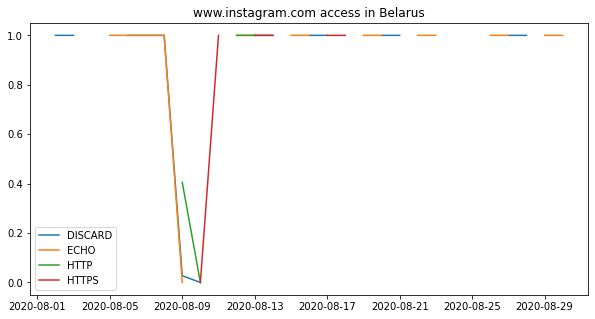

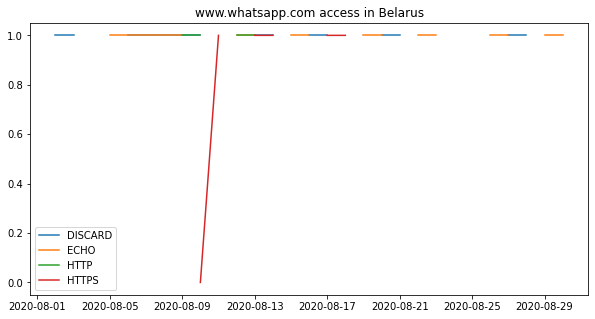

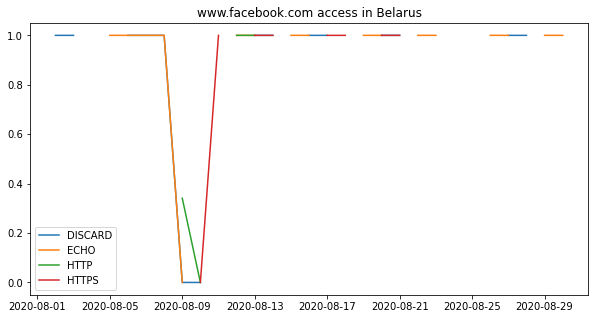

In [21]:
graph_domain('www.instagram.com')
graph_domain('www.whatsapp.com')
graph_domain('www.facebook.com')

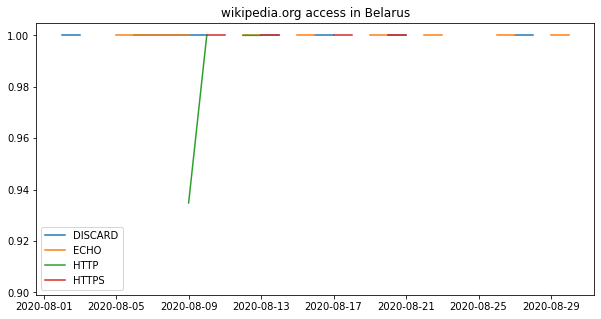

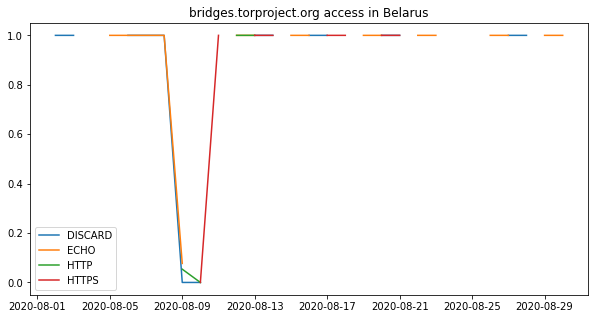

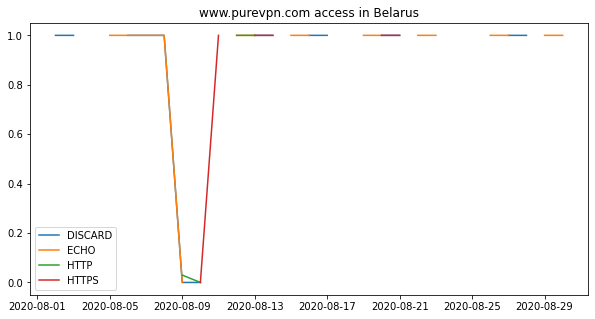

In [22]:
graph_domain('wikipedia.org')  # not social media, so we expect no blocking
graph_domain('bridges.torproject.org')
graph_domain('www.purevpn.com')

In [23]:
# Lets looks at only HTTPS data for now
source_ratios = dated_both_ratios[dated_both_ratios['source'].eq('HTTPS')]

total_by_domain = source_ratios.sort_values(['date'])[['date', 'total_count', 'domain']]
total = total_by_domain.pivot(index='date', columns='domain', values='total_count').transpose()

total[:10]

date,2020-08-03,2020-08-06,2020-08-10,2020-08-11,2020-08-13,2020-08-14,2020-08-17,2020-08-18,2020-08-20,2020-08-21,2020-08-24,2020-08-27
domain,,,,,,,,,,,,
0klxjejyxak3.com,31.0,32.0,10.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN,32.0,34.0
104.com.tw,31.0,31.0,10.0,1.0,33.0,1.0,2.0,31.0,2.0,29.0,32.0,34.0
11st.co.kr,32.0,31.0,8.0,NaN,33.0,NaN,2.0,31.0,NaN,NaN,32.0,34.0
123rf.com,31.0,31.0,8.0,1.0,33.0,1.0,2.0,31.0,NaN,NaN,32.0,34.0
126.com,31.0,31.0,7.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN,32.0,34.0
1337x.to,31.0,31.0,7.0,1.0,33.0,1.0,4.0,30.0,NaN,31.0,32.0,34.0
1688.com,31.0,31.0,7.0,1.0,33.0,1.0,3.0,30.0,NaN,31.0,32.0,34.0
17ok.com,31.0,31.0,7.0,1.0,33.0,1.0,2.0,31.0,NaN,NaN,32.0,34.0
17track.net,31.0,32.0,11.0,1.0,33.0,1.0,3.0,30.0,1.0,30.0,32.0,34.0


In [24]:
interference_by_domain = source_ratios.sort_values(['date'])[['date', 'interference_ratio', 'domain']]
interference = interference_by_domain.pivot(index='date', columns='domain', values='interference_ratio').transpose()

interference[:10]

date,2020-08-03,2020-08-06,2020-08-10,2020-08-11,2020-08-13,2020-08-14,2020-08-17,2020-08-18,2020-08-20,2020-08-21,2020-08-24,2020-08-27
domain,,,,,,,,,,,,
0klxjejyxak3.com,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
104.com.tw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11st.co.kr,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0
123rf.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
126.com,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1337x.to,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
1688.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
17ok.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
17track.net,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# pick some domains we're interested in

select_domains = ['psiphon.ca',
                  'youtube.com',
                  'google.com',
                  'encrypted.google.com',
                  'www.instagram.com',
                  'www.whatsapp.com',
                  'www.facebook.com',
                  'wikipedia.org',
                  'bridges.torproject.org',
                  'www.purevpn.com']

select_total = total[total.index.get_level_values('domain').map(lambda domain: domain in select_domains)]

select_interference = interference[interference.index.get_level_values('domain').map(lambda domain: domain in select_domains)]
select_total

date,2020-08-03,2020-08-06,2020-08-10,2020-08-11,2020-08-13,2020-08-14,2020-08-17,2020-08-18,2020-08-20,2020-08-21,2020-08-24,2020-08-27
domain,,,,,,,,,,,,
bridges.torproject.org,31.0,31.0,35.0,1.0,33.0,1.0,2.0,31.0,1.0,30.0,32.0,34.0
encrypted.google.com,32.0,31.0,40.0,1.0,33.0,1.0,2.0,31.0,1.0,30.0,32.0,34.0
google.com,31.0,31.0,47.0,1.0,33.0,1.0,2.0,32.0,1.0,30.0,32.0,34.0
psiphon.ca,31.0,32.0,30.0,1.0,129.0,1.0,15.0,109.0,5.0,101.0,159.0,161.0
wikipedia.org,31.0,31.0,8.0,1.0,33.0,1.0,2.0,32.0,2.0,29.0,32.0,34.0
www.facebook.com,31.0,31.0,42.0,1.0,33.0,1.0,1.0,33.0,1.0,30.0,32.0,34.0
www.instagram.com,31.0,32.0,55.0,1.0,33.0,1.0,3.0,30.0,NaN,31.0,32.0,34.0
www.purevpn.com,31.0,31.0,18.0,1.0,33.0,1.0,NaN,33.0,1.0,30.0,32.0,34.0
www.whatsapp.com,32.0,32.0,56.0,1.0,33.0,1.0,3.0,31.0,NaN,32.0,32.0,34.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


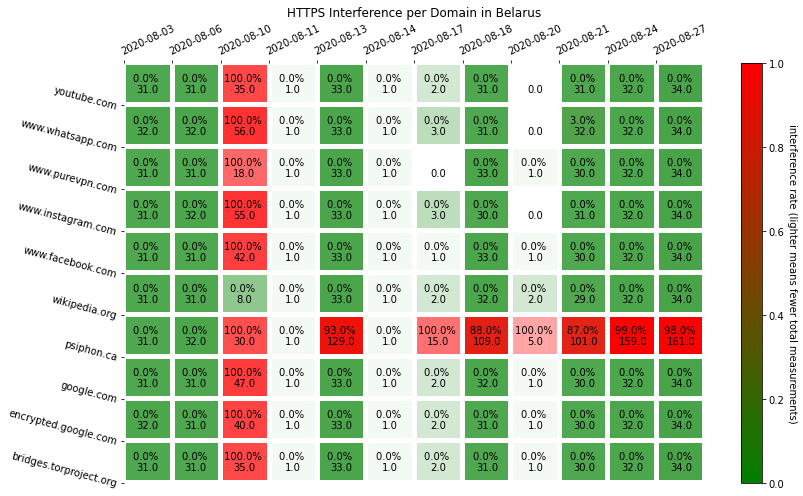

In [26]:
def graph_heatmap(inf, totals, figsize=(12, 7), margins={'x':.04, 'y':.05}):
  # figsize - used to adjust the total size of the figure
  # margins - used to adjust the outer margin around the cell labels
  # adjust these values to fix fiddly display issues

  dates = inf.columns
  domains = inf.transpose().columns

  data = inf.to_numpy()
  transparencies = np.nan_to_num(totals.to_numpy())
  # log scale so we mostly lighten cells with very few measurements
  # (so cells at the halfway value are more than halfway visible)
  # but also add a bump so there's a visible difference between 0 and 1 measurement
  transparencies_log = np.log(transparencies) + .05 * np.max(np.log(transparencies))
  transparencies_normed = transparencies_log/np.max(transparencies_log)

  fig, ax = plt.subplots(figsize=figsize)

  # make a colorbar that is dark green-brown-red and has no lighter sections
  # so we can use lighter colors to indicate fewer measurements instead
  colormap=matplotlib.colors.LinearSegmentedColormap.from_list('gr',["g", "r"], N=256) 

  # draw cells
  im = ax.pcolormesh(data, edgecolors='w', linewidths=4, cmap=colormap)

  ax.set_xticks(np.arange(len(dates)))
  ax.set_xticklabels(dates)
  ax.xaxis.tick_top()
  plt.setp(ax.get_xticklabels(), rotation=25, ha="left",
           rotation_mode="anchor")

  ax.set_yticks(np.arange(len(domains)))
  ax.set_yticklabels(domains)
  plt.setp(ax.get_yticklabels(), rotation=-15, ha="right",
           rotation_mode="anchor")
  
  for edge, spine in ax.spines.items():
    spine.set_visible(False)

  # Loop over data dimensions and create text annotations.
  for i, i_px in zip(range(len(domains)), np.linspace(margins['y'],1-margins['y'],len(domains))):
    for j, j_px in zip(range(len(dates)), np.linspace(margins['x'],1-margins['x'],len(dates))):

      interference_label = str(round(data[i, j] * 100, 0)) + "%"
      if math.isnan(data[i, j]):
        interference_label = ""
      total_label = str(round(transparencies[i, j], 2))
      label = interference_label + " \n" + total_label

      text = ax.text(j_px, i_px, label,
                     ha="center", va="center",
                     color='k', transform=ax.transAxes)
      
  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel("interference rate (lighter means fewer total measurements)",
                     rotation=-90, va="baseline", ha="center")

  ax.set_title('HTTPS Interference per Domain in Belarus')

  fig.tight_layout()
  plt.box(False)

  # set transparencies for the cells
  # this is a weird hack, so it has to come after other fig manipulation
  # https://stackoverflow.com/questions/32177718/use-a-variable-to-set-alpha-opacity-in-a-colormap
  fig.canvas.draw() # generate the facecolors array to modify
  for i,j in zip(im.get_facecolors(),transparencies_normed.flatten()):
    i[3] = j # Set the alpha value of the RGBA tuple using total values

  plt.show()

graph_heatmap(select_interference, select_total)

In [27]:
# graph all sites which have some substantial https interference on any day
interference_threshold = .3

nonzero_interference = interference.loc[(interference > interference_threshold).any(axis=1), :]
select_domains = nonzero_interference.transpose().columns

nonzero_totals = total[total.index.get_level_values('domain').map(lambda domain: domain in select_domains)]

print(len(nonzero_interference))
nonzero_interference[:10]

102


date,2020-08-03,2020-08-06,2020-08-10,2020-08-11,2020-08-13,2020-08-14,2020-08-17,2020-08-18,2020-08-20,2020-08-21,2020-08-24,2020-08-27
domain,,,,,,,,,,,,
ar.wikipedia.org,0.000000,0.000000,0.0,0.5,0.057143,0.0,0.0,0.000000,NaN,0.000000,0.000000,0.000000
bet9ja.com,0.348837,0.340909,0.0,0.0,0.333333,0.0,0.0,0.333333,0.00,0.365854,0.250000,0.238095
binance.com,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.142857,NaN,NaN
bitcoin.sipa.be,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.0,0.142857,0.00,0.171429,0.138889,0.131579
blockoption.io,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.000000,NaN,NaN,NaN,NaN
bridges.torproject.org,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000
cambridge.org,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.75,0.000000,0.000000,0.000000
coronavirus.app,NaN,NaN,NaN,1.0,NaN,1.0,NaN,0.408163,NaN,0.425532,NaN,NaN
de.wikipedia.org,0.000000,0.000000,0.0,0.5,0.000000,0.0,NaN,0.000000,0.00,0.000000,0.000000,0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


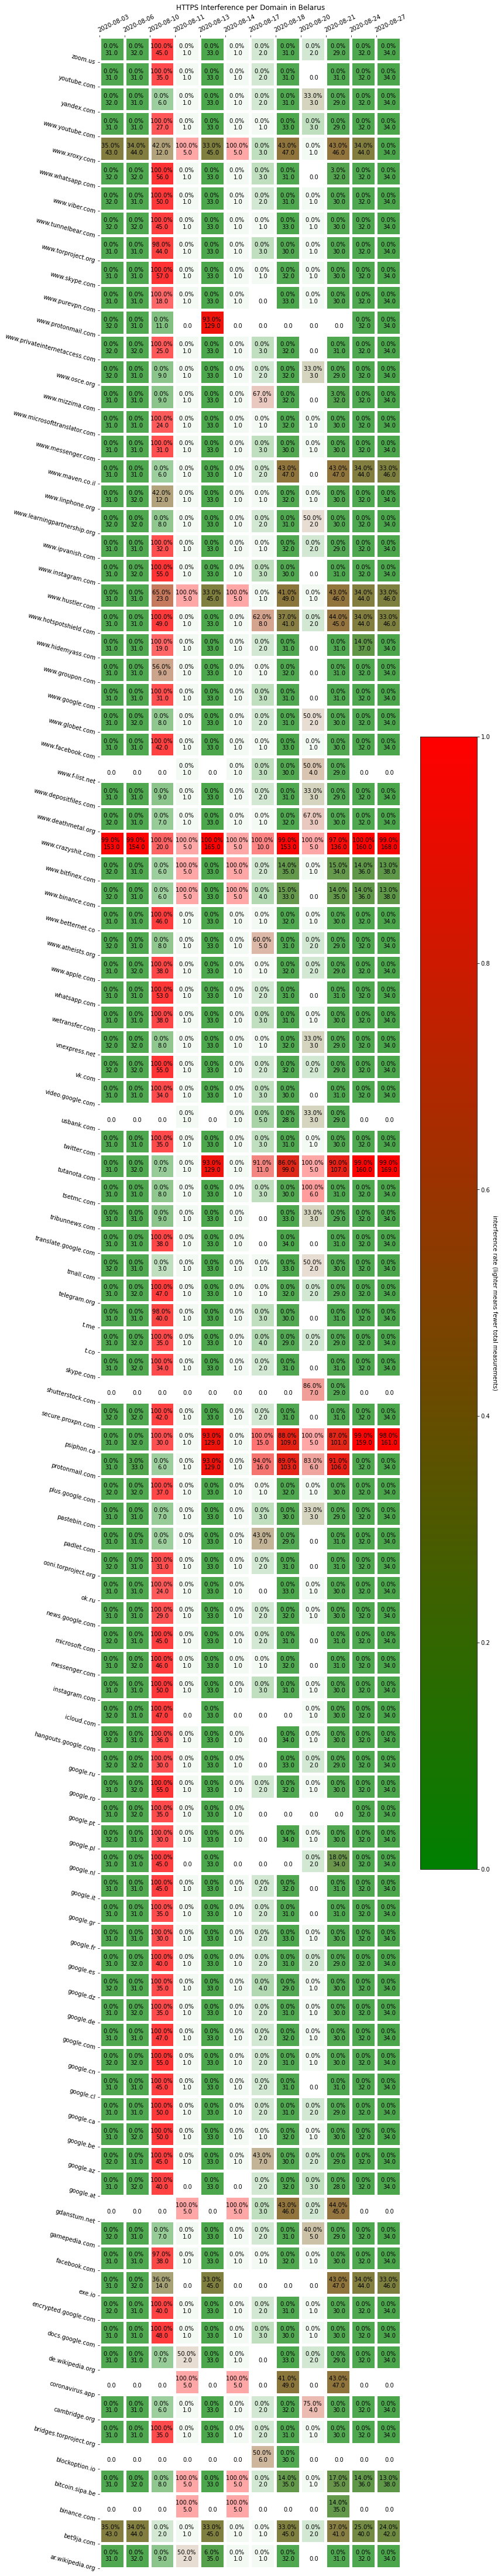

In [28]:
graph_heatmap(nonzero_interference, nonzero_totals, figsize=(12, len(nonzero_interference)*.6), margins={'x':.04, 'y':.005})

1023


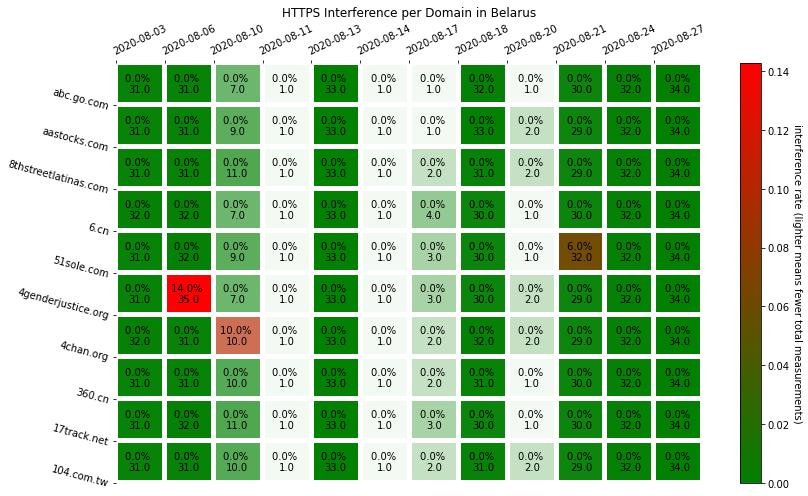

In [29]:
# also graph some sites with no substantial interference just for comparison
interference_threshold = .3

no_interference = interference.loc[(interference < interference_threshold).all(axis=1), :]
select_domains = no_interference.transpose().columns

no_totals = total[total.index.get_level_values('domain').map(lambda domain: domain in select_domains)]

print(len(no_interference))

graph_heatmap(no_interference[:10], no_totals[:10])